In [44]:
# Import required libraries
import os

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE" #Corrects crashing issues in windows

import numpy as np
import matplotlib.pyplot as plt
import pymoo

# pymoo sub sections
# from pymoo.core.problem import Problem
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.variable import Real, Integer, Choice, Binary
from pymoo.core.mixed import MixedVariableMating, MixedVariableGA, MixedVariableSampling, MixedVariableDuplicateElimination
from pymoo.optimize import minimize

# Utiliies for working with linkages (DeCoDE Lab)
from linkage_utils import *

# Other modules
import json
from IPython.display import HTML
import matplotlib.animation as animation
from tqdm.autonotebook import trange
import pickle


## Linkage Synthesis Challenge Problem

This challenge problem is focused on synthesizing planar linkage mechanisms such that a specific output curve is traced using the mechanism. For this project you are tasked with synthesizing linkage mechanisms to trace six different output shapes. Further, you are tasked with synthesizing mechanisms such that the total material used for the mechanisms in minimized.

### Overview
The first portion of this notebook will help you understand the linkage design problem and the way we parameterize each linkage design. It will also discuss deliverables and submission instructions. In the second half of this notebook we provide you with a working implementation that you can use as a baseline. **IMPORTANT:** We also provide a **supplementary notebook** with important implementation details and auxiliary information. We highly encourage students to go through this auxiliary notebook after getting oriented with this one. We also provide numerous helper functions in the linkage_utils. We touch on some of these functions in this notebook and go into more details in the supplementary notebook.

### Project Files and Description of Functions Provided:

All files as well as helper functions and the supplementary notebook and further information can be found in the Github repository of this challenge problem:

[Github Repo](https://github.com/ahnobari/MOOMP)


### Mechanism Representation

For this project, we represent planar mechanisms using the following components:
<ol>
    <li><b>Adjacency/Connectivity Matrix: </b>A linkage mechanisms structure can be represented using a matrix of connectivity (C), which is similar to the adjacency matrix in graphs (networks). The connectivity matrix for a mechanisms with $N$ nodes is a symmetric $N\times N$ matrix with each row and column representing each node and its connections to other nodes. Take the example below:

<img src="https://transportgeography.org/wp-content/uploads/simple_connectivity_matrix2.png" alt="Connectivity Matrix">

For Node A we use the first row/column of the matrix and we see that A is connected to B (which is represented by the second row/column). To represent this connection in the connectivity matrix we will set the value of the $(1,2)$ and $(2,1)$ elements of the matrix to be 1. Similarly any time any nodes $i$ and $j$ are connected we set the value of the $(i,j)$ and $(j,i)$ elements to be 1 and 0 if the nodes are not connected.</li>
    <li><b>Node Types: </b>To define the mechanism we must also know which nodes are fixed (or ground nodes). For this purpose we store the list of  ground nodes' numbers.</li>
    <li><b>Motor: </b>To simulate the kinematics of the mechanism we also need to know which linkage is driven (i.e., has the motor attached to it). For this purpose we store the numbers of the two nodes that the driven linkage is connected to.</li>
    <li><b>Initial Positions: </b>Finally, we need to know the initial positions of the nodes that make up the mechanism. For this we store the $x,y$ positions of the nodes in a list. Note that all node positions must be floating point numbers between 0 and 1 (i.e., The initial positions of the mechanism must fit into a box of 1x1).</li>
</ol>

#### Example:
Take the following mechanism (Note that node numbers are started from 0 in our representation):

<img src="https://i.ibb.co/qsPC0gC/2021-09-13-0hl-Kleki.png" alt="Numbered Mechanism" border="0">

For this example mechanism we have the following Connectivity Matrix (<code>C</code>), initial positions matrix (<code>x0</code>), motor linkage (<code>motor</code>), and a list of fixed nodes(<code>fixed_nodes</code>):

**Drawing mechanisms:** To visualize this in python we have provided the <code>draw_mechanism(C,x0,fixed_nodes,motor)</code> function to you in the <code>linkage_utils</code> module.

In [45]:
def T(C, x):
  for row in range(len(x)):
    for col in range(len(x[0]- row)):
      if C[row][col] == 1:
        
        x[row][col] = x[row][col] + 0.1

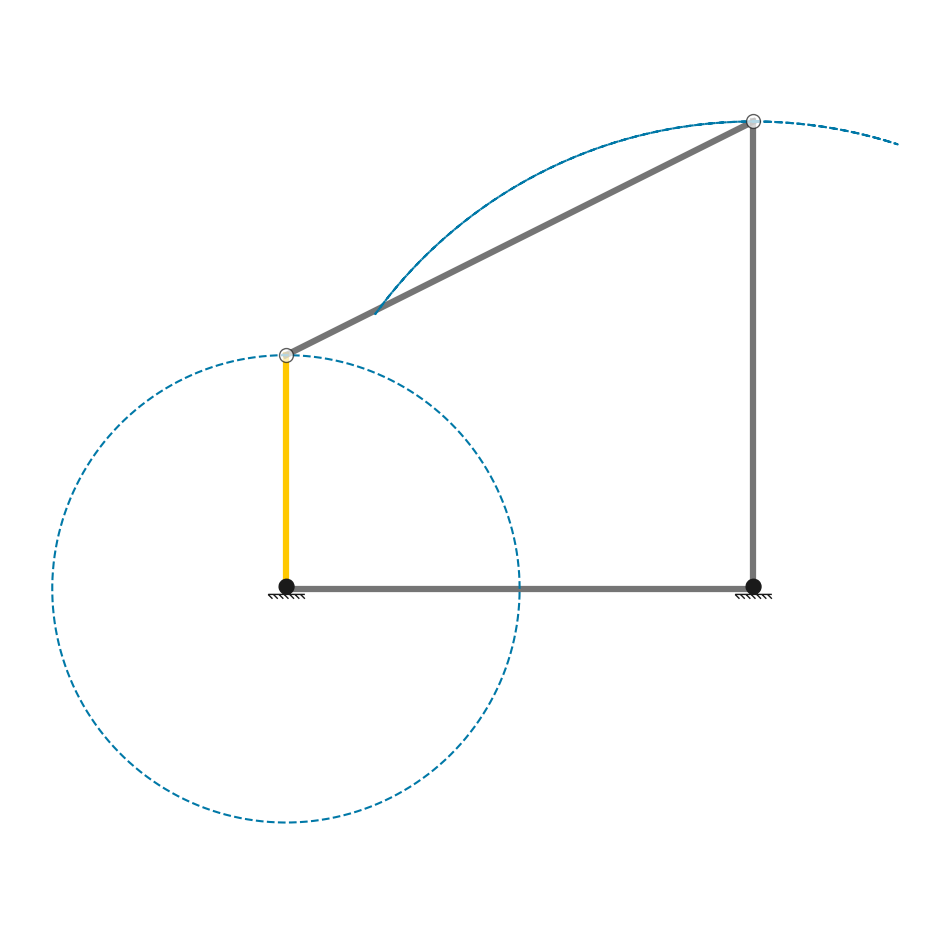

In [46]:
# Manualy define the connectivity matrix
C = np.array([[0,1,1,0],
              [1,0,0,1],
              [1,0,0,1],
              [0,1,1,0]])

# List of fixed nodes
fixed_nodes = np.array([0,1])

# Initial positions
x0 = np.array([[0.4,0.5],
               [0.6,0.5],
               [0.4,0.6],
               [0.6,0.7]])

# Motor
# Note: motor[0] is the driving node and motor[1] is being driven around Motor[0]
motor = np.array([0,2])
draw_mechanism(C,x0,fixed_nodes,motor)

In [47]:
# Initialize an empty list to store target curves
target_curves = []

# Loop to read 6 CSV files and store data in target_curves list
for i in range(6):
    # Load data from each CSV file and append it to the list
    target_curves.append(np.loadtxt('./data/%i.csv'%(i),delimiter=','))

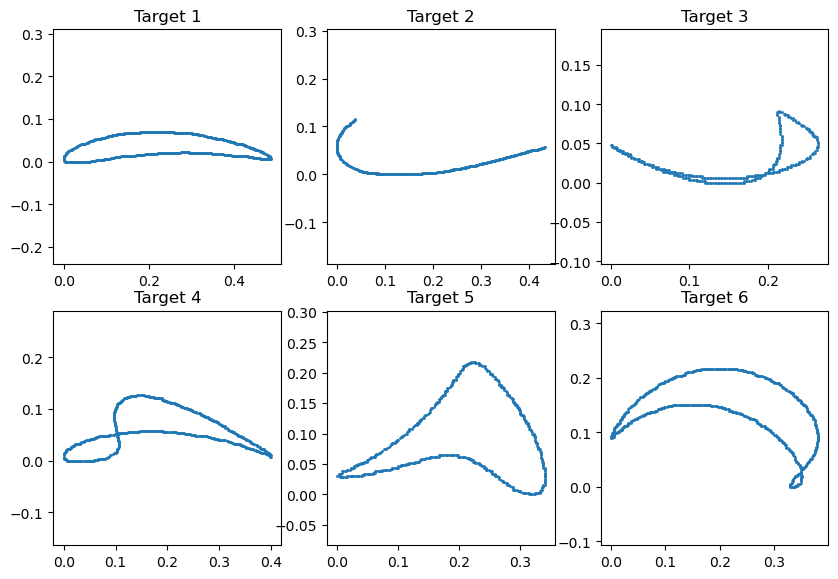

In [48]:
# # Plot all target curves

# Initialize a 2x3 subplot for plotting all target curves
fig, axs = plt.subplots(2, 3, figsize=(10, 6.7))

# Loop through the 6 target curves to plot them
for i in range(6):
    # Extract x and y coordinates from the target curve
    x_coords = np.array(target_curves[i])[:, 0]
    y_coords = np.array(target_curves[i])[:, 1]

    # Plot the curve on the respective subplot
    axs[i // 3, i % 3].scatter(x_coords, y_coords, s=1)

    # Set title for each subplot
    axs[i // 3, i % 3].set_title(f'Target {i + 1}')

    # Ensure equal scaling for x and y axes
    axs[i // 3, i % 3].axis('equal')


In [49]:
class mechanism_synthesis_optimization(ElementwiseProblem):

    # When intializing, set the mechanism size and target curve
    def __init__(self, target_point_cloud, C, N = 5):
        self.C = C
        self.N = N
        variables = dict()

        # The upper triangular portion of our NxN Connectivity Matrix consists of Nx(N-1)/2 boolean variables:
        # for i in range(N):
        #     for j in range(i):
        #         variables["C" + str(j) + "_" + str(i)] = Binary()

        # We Delete C0_1 since we know node 1 is connected to the motor
        # del variables["C0_1"]

        #Our position matrix consists of Nx2 real numbers (cartesian coordinate values) between 0 and 1
        for i in range(2*N):
            variables["X0" + str(i)] = Real(bounds=(0.0, 1.0))

        # Our node type vector consists of N boolean variables (fixed vs non-fixed)
        for i in range(N):
            variables["fixed_nodes" + str(i)] =  Binary(N)

        # Our target node is an integer between 1 and N-1, (any except the motor node).
        variables["target"] = Integer(bounds=(1,N-1))

        # Set up some variables in the problem class we inherit for pymoo
        # n_obj=number of objectives, n_constr=number of constraints
        # Our objectives are chamfer distance and material, and they both have constraints.
        super().__init__(vars=variables, n_obj=2, n_constr=2)

        # Store the target curve point cloud
        self.tpc = target_point_cloud


    def convert_1D_to_mech(self, x):
        N = self.N

        # Get target node value
        target = x["target"]

        # Build connectivity matrix from its flattened constitutive variables
        # C = np.zeros((N,N))
        # x["C0_1"] = 1

        # for i in range(N):
        #     for j in range(i):
        #         C[i,j] = x["C" + str(j) + "_" + str(i)]
        #         C[j,i] = x["C" + str(j) + "_" + str(i)]

        # Reshape flattened position matrix to its proper Nx2 shape
        x0 = np.array([x["X0" + str(i)] for i in range(2*N)]).reshape([N,2])

        # Extract a list of Nodes that are fixed from boolean fixed_nodes vector
        fixed_nodes = np.where(np.array([x["fixed_nodes" + str(i)] for i in range(N)]))[0].astype(int)

        #We fix the motor and original ground node as 0 and 1 respectively in this implementation
        motor=np.array([0,1])

        return target, self.C, x0, fixed_nodes, motor

    def _evaluate(self, x, out, *args, **kwargs):
        #Convert to mechanism representation
        target, C, x0, fixed_nodes, motor = self.convert_1D_to_mech(x)

        #Call our evaluate function to get validity, CD, and material use
        valid, CD, mat, _ = evaluate_mechanism(C,x0,fixed_nodes, motor, self.tpc, idx=target, device='cpu',timesteps=2000)

        # check to see if the mechanism is valid
        if not valid:
            # if mechanism is invalid set the objective to infinity
            out["F"] = [np.Inf,np.Inf]
            out["G"] = [np.Inf, np.Inf]
        else:
            out["F"] = [CD,mat]

            # Set constraints as CD<=0.1 and Material<=10
            # Be careful about modifying these - designs that
            # violate the problem constraints will not be scored.
            out["G"] = [CD - 0.1, mat - 10]

    # def convert_mech_to_1D(C,x0,fixed_nodes,motor, target, N):
    #     variables = dict()
    #     for i in range(N):
    #         for j in range(i):
    #             variables["C" + str(j) + "_" + str(i)] = C[i,j]

    #     del variables["C0_1"]

    #     for i in range(2*N):
    #         variables["X0" + str(i)] = x0.flatten()[i]

    #     for i in range(N):
    #         variables["fixed_nodes" + str(i)] = i in fixed_nodes

    #     variables["target"] = target

    #     return variables


In [50]:
import numpy as np
from pymoo.indicators.hv import HV

def step_D(matrix):
    n = matrix.shape[0]
    # Initialize list to store augmented matrices
    augmented_matrices = []

    # Iterate over all pairs of nodes i < j
    for i in range(n):
        for j in range(i+1, n):
            # Check if there is a link between node i and node j
            if matrix[i][j] == 1:
                # Create a copy of the original matrix and resize it to (n+1) x (n+1)
                new_matrix = np.zeros((n+1, n+1), dtype=int)
                new_matrix[:n, :n] = matrix
                # Connect the new node (n) to node i and node j
                new_matrix[n][i], new_matrix[i][n] = 1, 1
                new_matrix[n][j], new_matrix[j][n] = 1, 1
                # Append the augmented matrix to the list
                augmented_matrices.append(new_matrix)

    return augmented_matrices


def step_T(matrix):
    n = matrix.shape[0]

    augmented_matrices = []

    for i in range(n):
        for j in range(i+1, n):
            if matrix[i][j] == 1:
                # Remove the original linkage
                matrix[i][j], matrix[j][i] = 0, 0

                # Adding a new node connecting with the previous node i and node j
                new_matrix = np.zeros((n+1, n+1), dtype=int)
                new_matrix[:n, :n] = matrix

                # Connect the new node n to node i and node j
                new_matrix[n][i], new_matrix[i][n] = 1, 1
                new_matrix[n][j], new_matrix[j][n] = 1, 1

                # For every other node k in matrix, except node i and j, connect node k and node n
                for k in range(n):
                    if k != i and k != j:
                        new_matrix[n][k], new_matrix[k][n] = 1, 1

                augmented_matrices.append(new_matrix)

                # Restore the original link before next iteration to keep the matrix unchanged for subsequent pairs
                matrix[i][j], matrix[j][i] = 1, 1

    return augmented_matrices


def pymoo_optimize(C, target_index, pop_size=100, n_gen=100):
    n = C.shape[0]
    target_curve = np.array(target_curves[target_index])

    problem = mechanism_synthesis_optimization(target_curve, C, n)

    # Set up GA with pop size of 100 -- see pymoo docs for more info on these settings!
    algorithm = NSGA2(pop_size=pop_size, sampling=MixedVariableSampling(),
                    mating=MixedVariableMating(eliminate_duplicates=MixedVariableDuplicateElimination()),
                    eliminate_duplicates=MixedVariableDuplicateElimination())

    # Run for 100 generations -- see pymoo docs for more info on these settings!
    results = minimize(problem,
                    algorithm,
                    ('n_gen', n_gen),
                    verbose=False,
                    save_history=True
                    )
    return results, problem

def get_score(results):

    hypervolume = float("-inf")

    if not results.X is None:
        #Specify reference point
        ref_point = np.array([0.1, 10])

        #Calculate Hypervolume
        ind = HV(ref_point)
        hypervolume = ind(results.F)

        #Print and plot
        print('Hyper Volume ~ %f' %(hypervolume))

    return hypervolume


best_score = float("-inf")
best_res = None
best_problem = None

def try_step_size(target_index, curr_C, N, pop_size, n_gen):  # Search till depth=N
    global best_problem
    global best_res
    global best_score
    if N == 0:
        return

    # Fixed Con matrix
    # pymoo only optimizes initial positions, num of vars would be < 20
    for step_f in [step_D, step_T]:
        Cs = step_f(curr_C)
        print(f"len(Cs) : {len(Cs)})")
        for C in Cs:
            print(f"{step_f.__name__}, N : {15-N}")
            result, problem = pymoo_optimize(C, target_index, pop_size, n_gen)  # Optimize only positions. Does not modify Graph
            score = get_score(result)
            if not score:
                continue
            if score > best_score:
                best_score = score  # Assign the score to best_score
                best_res = result
                best_problem = problem

            # Recursive call
            try_step_size(target_index, C, N-1, pop_size, n_gen)

C0 =  np.array([[0,1,1,0],
                [1,0,0,1],
                [1,0,0,1],
                [0,1,1,0]])


try_step_size(0, C0, 1, pop_size=300, n_gen=1000)
# Test_DT
# res0, res_problem0 = func(target_index=0, N=1, pop_size=20, n_gen=50)
# res1, res_problem1 = func(target_index=1, N=20, pop_size=200, n_gen=1000)

len(Cs) : 4)
step_D, N : 14


KeyboardInterrupt: 

In [ ]:
def submit(target_idx, res, res_problem):
    i = target_idx
    mechanisms = []
    for x in res.X:
        target, C, x0, fixed_nodes, motor  = res_problem.convert_1D_to_mech(x)
        mechanisms.append(to_final_representation(C,x0,fixed_nodes,motor,target))
    save_population_csv('./results/%i.csv'%i,mechanisms)


# submit(target_idx=0, res=best_res, res_problem=best_problem)

In [64]:
!python evaluate.py

^C


In [ ]:
def comparecurves(C, x, fixed_nodes, motor, target, target_pc):
    valid, CD, mat, sol = evaluate_mechanism(C,x,fixed_nodes, motor, target_pc, idx=target,device='cpu',timesteps=2000)
    target_pc = get_oriented(target_pc)
    plt.scatter(sol[:,0],sol[:,1],s=2)
    plt.scatter(target_pc[:,0],target_pc[:,1],s=2)
    plt.title(f"Chamfer Distance: {CD}")
    plt.axis('equal')


def compare_curves(target_idx, i):
    population_reloaded = get_population_csv('results/' + str(target_idx) +'.csv')
    C, x0, fixed_nodes, motor, target = from_1D_representation(population_reloaded[i])
    comparecurves(C, x0, fixed_nodes, motor, i, target_curves[target_idx])

In [53]:
valid, CD, mat, sol = evaluate_mechanism(C,x0,fixed_nodes, motor, target_curves[0], idx=0,device='cpu',timesteps=2000)

In [62]:
mechanisms = get_population_csv('./results/0.csv')
F = []
for m in mechanisms:
    C, x0, fixed_nodes, motor, target = from_1D_representation(m)

                # Solve
    valid, CD, material, _ = evaluate_mechanism(
    C, x0, fixed_nodes, motor, target_curves[i], target, device='cpu', timesteps=2000)
    print([CD, material])
    print(hyper_volume(np.array([CD, material]), [0.1, 10.0]))

[0.1418729157584357, 7.082791119813919]
0.0
[0.1822892053508281, 0.5593485489953309]
0.0
[0.14237044962214312, 6.49964864552021]
0.0
[0.1373487456466227, 4.450507700443268]
0.0
[0.12896957413409382, 2.634139783680439]
0.0
[0.1307152352827598, 3.174924924969673]
0.0
[0.13898732362981517, 4.381393760442734]
0.0
[0.13630296877316725, 4.148330979049206]
0.0
[0.17217597667904438, 0.5729025030159391]
0.0
[0.13296658971982095, 3.66604938544333]
0.0
[0.12636152435111425, 2.1038516238331795]
0.0
[0.13570031392029375, 3.995777666568756]
0.0
[0.13365626214364934, 3.553498186171055]
0.0
[0.1500314702309598, 0.6806526649743319]
0.0
[0.1712362600902805, 0.5797836596611887]
0.0
[0.16007659448360267, 0.6886451147147454]
0.0
[0.1312047599504167, 3.397224634885788]
0.0
[0.11263062103876889, 1.7133286222815514]
0.0
[0.12662546306306147, 0.7075503682717681]
0.0
[0.13387009745797354, 1.9567760229110718]
0.0
[0.11284257433550943, 1.0052954787388444]
0.0
[0.18562759413548774, 0.566385036916472]
0.0
[0.134135

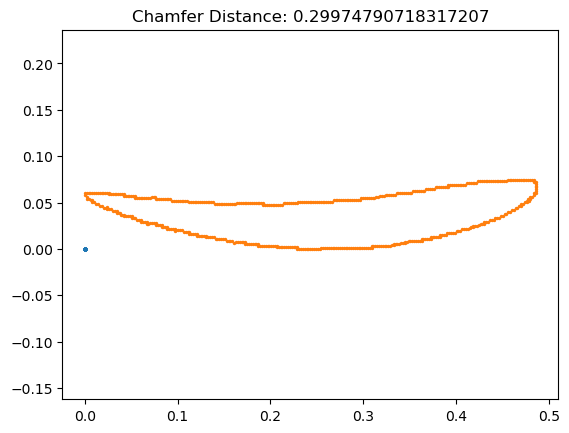

In [51]:
compare_curves(0, 2)

In [ ]:
def visualize_all(target_idx):
    population_reloaded = get_population_csv('results/' + str(target_idx) +'.csv')
    # Set up a 2x3 grid of plots
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))

    # Loop to plot 6 mechanisms from the population list
    for i in trange(6):
        # Convert 1D representation back to original variables
        C, x0, fixed_nodes, motor, target = from_1D_representation(population_reloaded[i])
        # Draw the mechanism on the respective subplot
        draw_mechanism_on_ax(C, x0, fixed_nodes, motor, axs[i // 3, i % 3])
visualize_all(target_idx=2)

Alternatively you can run the following command in the terminal (loaded to the main directory of the repo):

### Now Let's Get a Submission Going

Now lets run the process for all the target curves in a loop:

In [4]:
import time
start_time = time.time()

for i,target_curve in enumerate(target_curves):
    # Setup Problem
    problem = mechanism_synthesis_optimization(target_curve,5)

    # Get Algorithm
    algorithm = NSGA2(pop_size=100, sampling=MixedVariableSampling(),
                      mating=MixedVariableMating(eliminate_duplicates=MixedVariableDuplicateElimination()),
                      eliminate_duplicates=MixedVariableDuplicateElimination())

    results.X = None
    count=0
    while results.X is None and count!=2: #Total number of seeds to try

        # Run for 100 generations
        results = minimize(problem,
                           algorithm,
                           ('n_gen', 100),
                           verbose=True,
                           save_history=True,
                           seed=0+count,
                           display=best())
        if results.X is None:
            print('Did Not Find Solutions for Target ' + str(i) + '. Trying Seed ' + str(count+1+1) + '!')
            count+=1


    if results.X is None:
        print('Did Not Find Solutions for any Seed!!')
    else:
        mechanisms = []
        for x in results.X:
            target, C, x0, fixed_nodes, motor  = problem.convert_1D_to_mech(x)
            # target, C, x0, fixed_nodes, motor  = problem.fix_mechanism(target, C, x0, fixed_nodes, motor )
            mechanisms.append(to_final_representation(C,x0,fixed_nodes,motor,target))

        ref_point = np.array([0.1, 10])
        ind = HV(ref_point)
        hypervolume = ind(results.F)
        print('Hyper Volume ~ %f' %(hypervolume))
        plot_HV(results.F, ref_point)

        save_population_csv('./results/%i.csv'%i,mechanisms)
print("--- Execution time: %s seconds ---" % (time.time() - start_time))

NameError: name 'target_curves' is not defined

Now let's see how we did:

In [38]:
evaluate_submission()

100%|██████████| 6/6 [00:00<00:00, 39.88it/s]

Score Break Down:
Curve 0: 0.561200
Curve 1: 0.000000
Curve 2: 0.000000
Curve 3: 0.000000
Curve 4: 0.000000
Curve 5: 0.000000
Overall Score: 0.093533


0.09353335281658552